#Sentiment Analysis using Hugging Face Model.

This notebook is aimed at identifying the sentiment of reviews posted online using a Hugging Face model.  
The first step is to install transformers library current Colab notebook.  
PyTorch-Transformers is a library of state-of-the-art pre-trained models for Natural Language Processing (NLP). This library currently contains PyTorch implementations, pre-trained model weights, usage scripts and conversion utilities for the following models: BERT (from Google) GPT (from OpenAI)



In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.4 MB/s eta 0:00:00


In [29]:
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate Model
A tokenizer is initialized that will convert text into word vectors so it can be used by the BERT model to predict the sentiments.  
Next step is to instatiate the pre-trained model: "bert-base-multilingual-uncased-sentiment".  

In [3]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Sentiment on Sample Cases
Try sample cases to test the validity of the model.

In [4]:
#Encode the text using tokenizer
tokens = tokenizer.encode('Avengers End Game was a good movie but I wish Iron Man survived. Then it could have been much better. Great!', return_tensors = 'pt')
print("Tokens:", tokens)

Tokens: tensor([[  101, 49766, 11421, 11336, 10140,   143, 12050, 13113, 10502,   151,
         33020, 16228, 10564, 36201,   119, 11120, 10197, 12296, 10574, 10662,
         12977, 16197,   119, 11838,   106,   102]])


In [5]:
#Use model to predict sentiment
result = model(tokens)
print("Result from model:", result, "\n")

#logits contains numerical output of the model
print("Results logits:", result.logits, "\n") #refers to a rating of 0, 1, 2, 3, 4 classes or rating of 1 to 5

#Use argmax to find the strongest sentiment
print("Rating:", int(torch.argmax(result.logits))+1, "\n")

Result from model: SequenceClassifierOutput(loss=None, logits=tensor([[-2.3936, -1.1064,  0.9386,  1.7290,  0.5313]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None) 

Results logits: tensor([[-2.3936, -1.1064,  0.9386,  1.7290,  0.5313]],
       grad_fn=<AddmmBackward0>) 

Rating: 4 



# Scrape Reviews from Web
In the next step, we use beautifulsoup to scape reviews from the web and predict ratings using the intantiated model.

In [10]:
#Parse the webpage containing reviews
web_rev = requests.get('https://www.yelp.com/biz/south-fork-public-house-pullman-2?osq=south+fork')
soup = BeautifulSoup(web_rev.text, 'html.parser')
#Use regex to make a regular expression object of comment
regex = re.compile('.*comment.*')
#The find the regex object in 
results = soup.find_all('p', {'class':regex})
print("Results:", results, "\n")
reviews = [result.text for result in results]
print("Reviews:", reviews)

Results: [<p class="comment__09f24__gu0rG css-qgunke"><span class=" raw__09f24__T4Ezm" lang="en">Great service! Our waitress was great and she was very friendly. Food was great we finally tried the liquid gold cheese and it did not disappoint! We had the nachos and Mac and cheese.</span></p>, <p class="comment__09f24__gu0rG css-qgunke"><span class=" raw__09f24__T4Ezm" lang="en">South Fork has been a favorite dining experience for our family since it first opened. However, after ordering out from there this past week, I expect we may not ever go back. They put the cilantro penne pasta back on the menu which was very much appreciated, but the chicken gyros still gone. However, this is not why we doubt we will dine here in future . I ordered the seared salmon, and the salmon itself was wonderful. The problem was, it had such a thick coating of salt that I could only eat about half of it, and the asparagus was cooked to perfection, but so coated with  salt that  even after I rinsed it off 

# Load reviews into a dataframe

In [27]:
df = pd.DataFrame(np.array(reviews), columns = ['review'])
print("Shape of dataframe:", df.shape)
display(df.head())
print("\nA single review:\n",df.loc[0, 'review'])

Shape of dataframe: (14, 1)


,review
0,Great service! Our waitress was great and she ...
1,South Fork has been a favorite dining experien...
2,Thank you Valerie for taking the time to fill ...
3,This place has some really good entrees and ex...
4,"After a wonderful conversation with the owner,..."



A single review:
 Great service! Our waitress was great and she was very friendly. Food was great we finally tried the liquid gold cheese and it did not disappoint! We had the nachos and Mac and cheese.


# Predict sentiment score

Example:
Review: Great service! Our waitress was great and she was very friendly. Food was great we finally tried the liquid gold cheese and it did not disappoint! We had the nachos and Mac and cheese.
Sentiment Score: 5


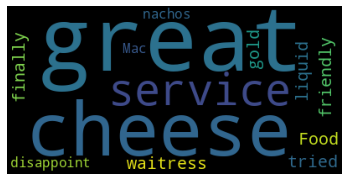

In [28]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors = 'pt')
    rating = model(tokens)
    return int(torch.argmax(rating.logits))+1

print(f"Example:\nReview: {df.loc[0, 'review']}\nSentiment Score: {sentiment_score(df.loc[0, 'review'])}")

#Let's visualize with a word cloud
text = df.loc[0, 'review']
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [36]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x))
display(df)

,review,sentiment
0,Great service! Our waitress was great and she ...,5
1,South Fork has been a favorite dining experien...,2
2,Thank you Valerie for taking the time to fill ...,4
3,This place has some really good entrees and ex...,5
4,"After a wonderful conversation with the owner,...",5
5,I'm not sure why the sudden change in South Fo...,2
6,I was visiting WSU and found this place highly...,5
7,Always a must go to spot when in Pullman. Grea...,5
8,"The food is consistently good here, and the se...",4
9,Do yourself a favor and eat here when you're i...,5


Let's have a look on the distribution of Ratings :


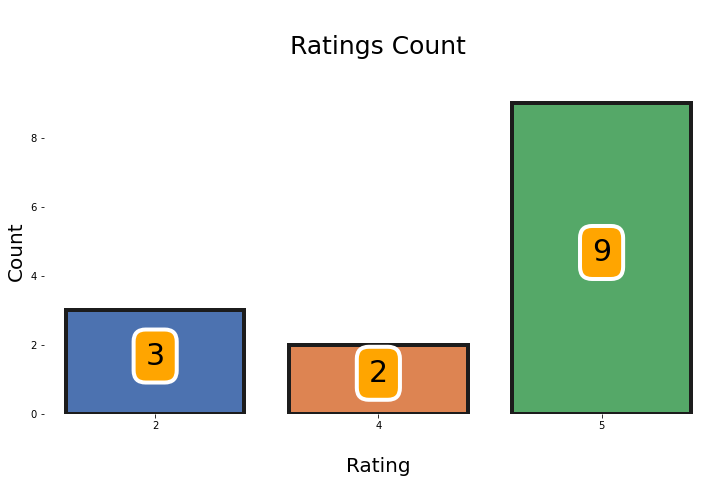

In [37]:
print(f"Let's have a look on the distribution of Ratings :")
plt.subplots(figsize=(12, 6))
sns.set(font_scale = 2)
p = sns.countplot(x = df["sentiment"], saturation=1, edgecolor = "#1c1c1c", linewidth = 4)
p.axes.set_yscale("linear")
p.axes.set_title("\nRatings Count\n",fontsize=25)
p.axes.set_ylabel("Count",fontsize=20)
p.axes.set_xlabel("\nRating",fontsize=20)
p.axes.set_xticklabels(p.get_xticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container, label_type = "center", padding = 6, size = 30,color = "black", rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "orange", "edgecolor": "white", "linewidth" : 4, "alpha": 1})
sns.despine(left=True, bottom=True)
plt.show()